In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_moons

In [2]:
X, y = make_moons(n_samples=100, noise=0.18, random_state=72)

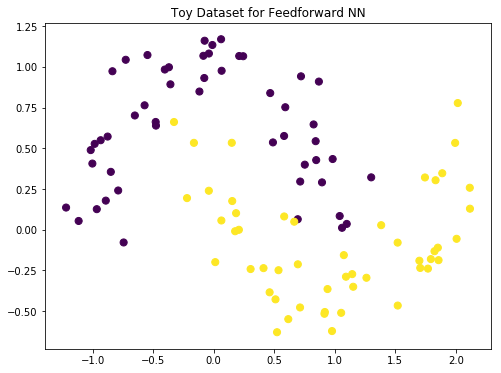

In [3]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X[:,0], X[:,1], c=y, s=50)
ax.set_title('Toy Dataset for Feedforward NN')
plt.show()

In [4]:
class NeuralNetwork():
    def __init__(self, X, y, lr=0.1, k_1=8, k_2=3, num_epochs=10000, random_state=0):
        self.X = X
        self.y = y
        self.lr = lr
        self.k_1 = k_1 # num of nodes in first hidden layer
        self.k_2 = k_2 # num of nodes in second hidden layer
        self.num_epochs = num_epochs
        self.rng = np.random.RandomState(random_state) # prng for reproducible results
        
        # setting dims for vectorization 
        self.m = X.shape[0]
        self.n = X.shape[1]
        self.y = y.reshape(1,self.m)
        self.X_T = X.T
        
        # initialization of model weights w/ small random values from N(0,0.1), biases w/ zeros
        self.W_1 = self.rng.randn(self.k_1,self.n)*0.1
        self.W_2 = self.rng.randn(self.k_2,self.k_1)*0.1
        self.W_3 = self.rng.randn(1,self.k_2)*0.1
        self.b_1 = np.zeros((self.k_1, 1))
        self.b_2 = np.zeros((self.k_2, 1))
        self.b_3 = np.zeros((1,1))
        
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _sigmoid_deriv(self, sigma):
        return sigma * (1 - sigma)
        
    def _forward_pass(self, X):
        self.Z_1 = np.dot(self.W_1, X.T) + self.b_1
        self.A_1 = self._sigmoid(self.Z_1)
        self.Z_2 = np.dot(self.W_2, self.A_1) + self.b_2
        self.A_2 = self._sigmoid(self.Z_2)
        self.Z_3 = np.dot(self.W_3, self.A_2) + self.b_3
        self.A_3 = self._sigmoid(self.Z_3)
        self.y_hat = self.A_3       
    
    def _backprop(self):
        # re-used for computing gradients (chain rule)
        d_Z_3 = (self.A_3 - self.y)
        d_Z_2 = np.dot(self.W_3.T, d_Z_3) * self._sigmoid_deriv(self.A_2) 
        d_Z_1 = np.dot(self.W_2.T, d_Z_2) * self._sigmoid_deriv(self.A_1)

        # update params w/ gradient descent
        self.W_3 -= self.lr * (1/self.m * np.dot(d_Z_3, self.A_2.T))
        self.b_3 -= self.lr * (1/self.m * np.sum(d_Z_3, axis=1)) 
        self.W_2 -= self.lr * (1/self.m * np.dot(d_Z_2, self.A_1.T))
        self.b_2 -= self.lr * (1/self.m * np.sum(d_Z_2, axis=1)).reshape(self.k_2, 1)
        self.W_1 -= self.lr * (1/self.m * np.dot(d_Z_1, self.X))
        self.b_1 -= self.lr * (1/self.m * np.sum(d_Z_1, axis=1)).reshape(self.k_1, 1)
        
    def log_loss(self, y, y_hat):
        y_hat = np.clip(y_hat, 1e-10, 1-1e-10) # y_hat must be in (0,1) to compute log loss
        return np.sum((-y*np.log(y_hat) - (1-y)*np.log(1-y_hat)))/self.m
    
    def train(self):
        self.loss_ = {}
        for i in range(self.num_epochs):
            self._forward_pass(self.X)
            self._backprop()
            if i%100==0:
                self.loss_[i] = self.log_loss(self.y, self.y_hat)
    
    def predict_proba(self, X):
        self._forward_pass(X)
        return self.y_hat
    
                    
    def predict(self, X):
        self._forward_pass(X)
        pred = np.where(self.y_hat>0.5, 1, 0)
        return pred
    
    def score(self, X, y):
        pred = self.predict(X)
        score = 1 - np.sum(pred != y)/self.m
        return score

In [5]:
nn = NeuralNetwork(X, y, k_1=8, k_2=3,lr=0.1, num_epochs=30000, random_state=0)

In [6]:
nn.train()
score = nn.score(X,y)
print("Feedforward Neural Network Accuracy: {}".format(score))

Feedforward Neural Network Accuracy: 1.0


In [7]:
from matplotlib.colors import ListedColormap
cmap1 = ListedColormap(['purple', 'yellow'])

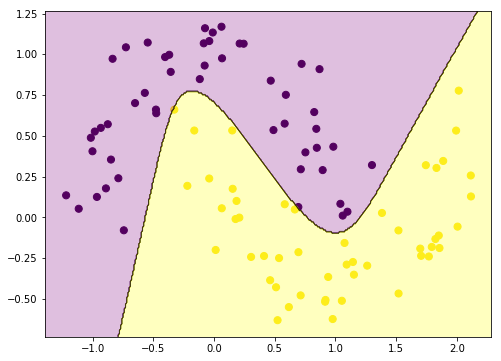

In [8]:
# scatter initial data 
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X[:,0], X[:,1], c=y, s=50)

# predict points in decision region
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
h=0.01
x_array = np.arange(xmin, xmax, h)
y_array = np.arange(ymin, ymax, h)
xx, yy = np.meshgrid(x_array, y_array)
zz = np.c_[xx.ravel(), yy.ravel()]
pred = nn.predict(zz).reshape(zz.shape[0], 1)
Z = pred.reshape(xx.shape)

# plot decision region/boundary
ax.contourf(xx, yy, Z, cmap=cmap1, alpha=0.25)
ax.contour(xx, yy, Z, colors='k', linewidths=0.2)
plt.show()